<a href="https://colab.research.google.com/github/bdmarvin1/log-file-analysis/blob/main/Chargebee_Log_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enterprise Log File Analysis: Chargebee Case Study
This notebook analyzes one year of server log data to diagnose crawl budget waste, identify spider traps, and explain indexing issues.

**Objective:** Identify why some pages are "Crawled - Currently Not Indexed" and optimize Googlebot's efficiency.

## Phase 1: Environment & Dependency Setup

In [46]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import socket
import gc
from datetime import datetime
from google.colab import auth
import gspread
from gspread.utils import rowcol_to_a1
from google.auth import default

# Mount Google Drive
drive.mount('/content/drive')

# Constants
LOGS_PATH = '/content/drive/MyDrive/Chargebee_Logs/'
OUTPUT_SHEET_NAME = 'Chargebee_Audit_Findings'

# iPullRank Brand Colors
IPR_YELLOW = '#FCD307'
IPR_BLUE = '#2A52BE'
IPR_BLACK = '#000000'
IPR_GREY = '#333333'
IPR_LIGHT_GREY = '#CCCCCC'

def get_ipr_colors(n, values=None):
    if n <= 0: return []
    grey_start = 51
    grey_end = 204
    if values is not None:
        v = np.array(values)
        if len(v) == 0: return []
        sorted_indices = np.argsort(v)[::-1]
        colors = ['#CCCCCC'] * len(v)
        num_greys = max(1, n - 2)
        grey_values = np.linspace(grey_start, grey_end, num_greys)
        for i, idx in enumerate(sorted_indices):
            if i == 0: colors[idx] = IPR_YELLOW
            elif i == 1: colors[idx] = IPR_BLUE
            else:
                grey_val = int(grey_values[i-2])
                colors[idx] = '#%02x%02x%02x' % (grey_val, grey_val, grey_val)
        return colors
    num_greys = max(1, n - 2)
    grey_values = np.linspace(grey_start, grey_end, num_greys)
    colors = []
    for i in range(n):
        if i == 0: colors.append(IPR_YELLOW)
        elif i == 1: colors.append(IPR_BLUE)
        else:
            grey_val = int(grey_values[i-2])
            colors.append('#%02x%02x%02x' % (grey_val, grey_val, grey_val))
    return colors

sns.set(style='whitegrid', palette=[IPR_BLUE, IPR_YELLOW, IPR_GREY])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Phase 2: Data Ingestion (Memory Optimized)
We process logs in chunks and filter for 'Googlebot' immediately to keep the memory footprint small.

In [47]:
def ingest_logs(directory_path, chunk_size=50000):
    all_files = glob.glob(os.path.join(directory_path, "*.csv"))
    if not all_files:
        print(f"No CSV files found in {directory_path}")
        return pd.DataFrame()

    googlebot_data = []
    rows_kept = 0
    total_rows_processed = 0

    # Columns we actually need to save memory
    use_cols = ['_time', 'useragent', 'uri_path', 'uri_query', 'status', 'bytes_sent', 'clientip', 'method', 'time_taken']

    for file in all_files:
        print(f"Processing {file}...")
        try:
            # Read in chunks to avoid OOM
            for chunk in pd.read_csv(file, usecols=use_cols, chunksize=chunk_size, low_memory=False):
                total_rows_processed += len(chunk)
                # Filter for Googlebot (case-insensitive)
                filtered_chunk = chunk[chunk['useragent'].str.contains("google", case=False, na=False)].copy()
                rows_kept += len(filtered_chunk)
                googlebot_data.append(filtered_chunk)

                # Aggressive garbage collection
                del chunk
                gc.collect()
        except Exception as e:
            print(f"Error processing {file}: {e}")

    if not googlebot_data:
        return pd.DataFrame()

    df = pd.concat(googlebot_data, ignore_index=True)
    print(f"Ingestion complete. Total Googlebot rows: {len(df)}")
    return df

df_raw = ingest_logs(LOGS_PATH)

Processing /content/drive/MyDrive/Chargebee_Logs/21. 06Augto10Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/22. 11Augto15Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/7. 01Junto05Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/5. may26-30.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/18. 21Julto25Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/9. 11Junto15Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/16. Jul11toJul15.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/8. 06Junto10Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/1. 12Aprto22Apr.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/11. 19jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/19. 26Julto31Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/6. May31.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/13. 24jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/17. 16Julto20Jul.csv...
Processin

## Phase 3: Data Cleaning & IP Verification

In [48]:
def verify_googlebot_ip(ip):
    """Performs Double-Reverse DNS lookup to verify Googlebot."""
    try:
        host = socket.gethostbyaddr(ip)[0]
        if not (host.endswith('.googlebot.com') or host.endswith('.google.com') or host.endswith('.googleusercontent.com')):
            return False

        addr = socket.gethostbyname(host)
        return addr == ip
    except (socket.herror, socket.gaierror):
        return False

def clean_data(df):
    if df.empty:
        return df

    # 1. Timestamp Conversion
    df['_time'] = pd.to_datetime(df['_time'])
    df.set_index('_time', inplace=True)

    # 2. IP Verification (Sample check if dataset is huge, or all unique IPs)
    unique_ips = df['clientip'].unique()
    print(f"Verifying {len(unique_ips)} unique IPs...")
    ip_map = {ip: verify_googlebot_ip(ip) for ip in unique_ips}
    df['is_verified_bot'] = df['clientip'].map(ip_map)

    # 3. File Type Categorization
    def get_file_type(path):
        if pd.isna(path): return 'Other'
        ext = os.path.splitext(path)[1].lower()
        if ext in ['', '.html', '.htm']: return 'HTML'
        if ext == '.js': return 'JS'
        if ext == '.css': return 'CSS'
        if ext in ['.jpg', '.jpeg', '.png', '.gif', '.svg', '.webp']: return 'Image'
        if ext in ['.json', '.xml']: return 'Data'
        return 'Other'

    df['file_type'] = df['uri_path'].apply(get_file_type)

    # 4. URL Normalization
    df['full_url'] = df['uri_path'] + df['uri_query'].fillna('')

    return df

df = clean_data(df_raw)
if not df.empty:
    print(f"Verified Bots: {df['is_verified_bot'].sum()} / {len(df)}")

Verifying 256 unique IPs...
Verified Bots: 0 / 720452


## Phase 4: Core Analysis Modules

### Module A: Crawl Volume & Frequency

/tmp/ipython-input-600712018.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bot_counts.index, y=bot_counts.values, palette=colors)


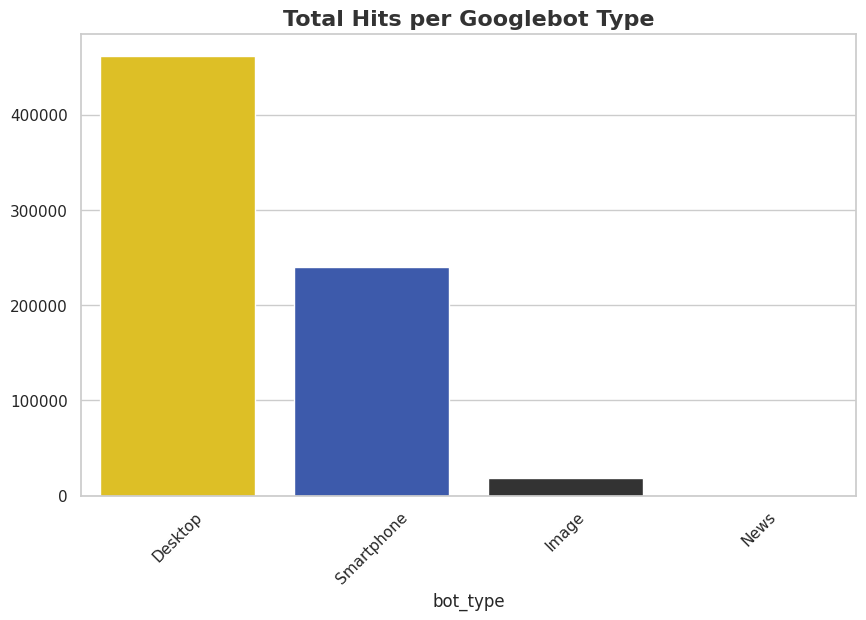

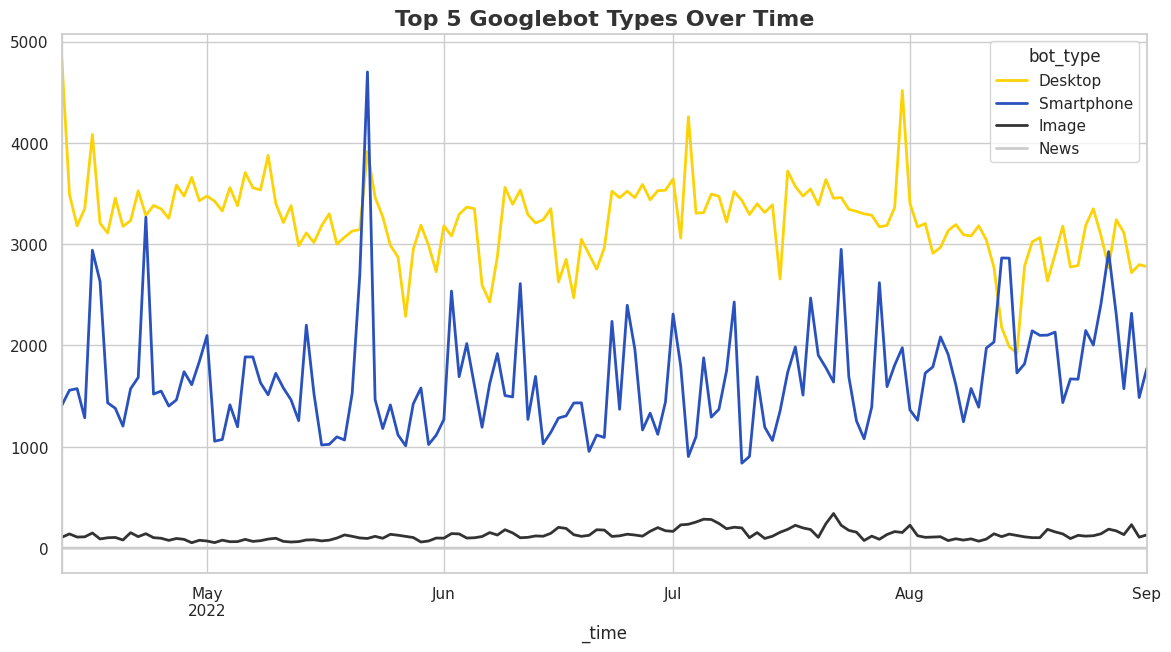

In [49]:
import re

def get_bot_type(ua):
    ua = str(ua)
    if re.search(r'Googlebot-Image', ua, re.I): return 'Image'
    if re.search(r'Googlebot-Video', ua, re.I): return 'Video'
    if re.search(r'Googlebot-News', ua, re.I): return 'News'
    if re.search(r'Storebot-Google', ua, re.I): return 'StoreBot'
    if re.search(r'AdsBot-Google', ua, re.I): return 'AdsBot'
    if re.search(r'Mediapartners-Google', ua, re.I): return 'AdSense'
    if re.search(r'Google-InspectionTool', ua, re.I): return 'Inspection Tool'
    if re.search(r'Googlebot', ua, re.I):
        if re.search(r'Mobile|Android|iPhone', ua, re.I): return 'Smartphone'
        return 'Desktop'
    return 'Other Google/Unknown'

df['bot_type'] = df['useragent'].apply(get_bot_type)
bot_counts = df['bot_type'].value_counts()

plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bot_counts), values=bot_counts.values)
sns.barplot(x=bot_counts.index, y=bot_counts.values, palette=colors)
plt.title('Total Hits per Googlebot Type', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.xticks(rotation=45)
plt.show()

top_5_bots = bot_counts.head(5).index.tolist()
bot_time_series = df[df['bot_type'].isin(top_5_bots)].groupby(['bot_type']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
line_colors = get_ipr_colors(len(top_5_bots), values=[bot_counts[b] for b in top_5_bots])
bot_time_series[top_5_bots].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Top 5 Googlebot Types Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

### Module B: Status Code Health

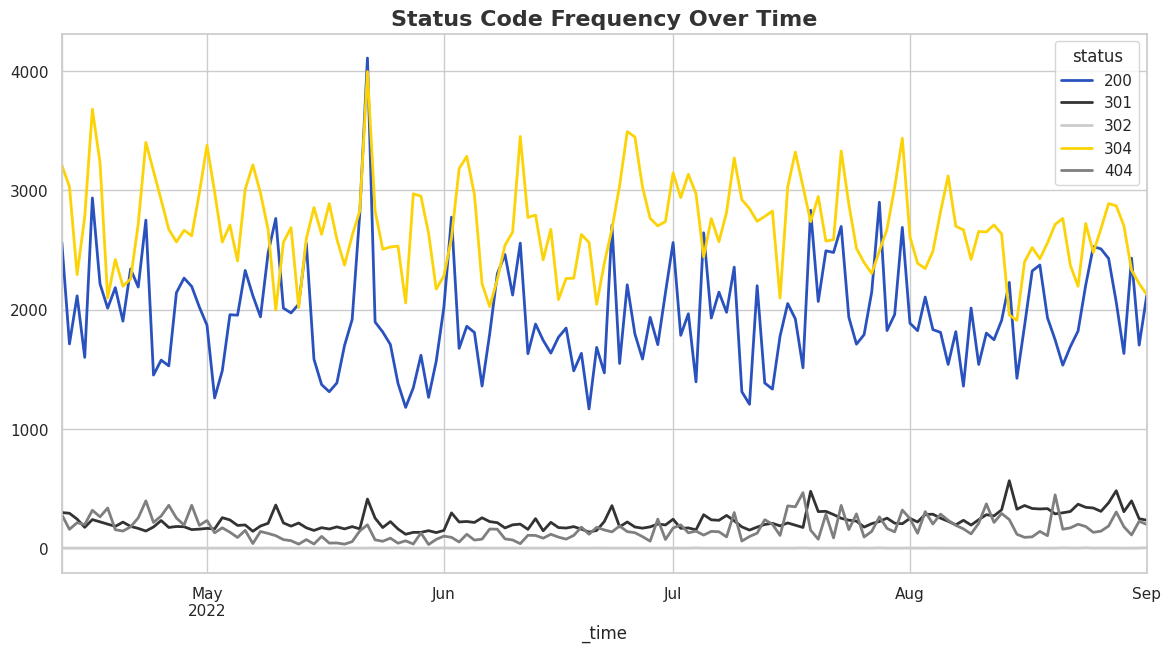

In [50]:
status_summary = df.groupby(['status', 'file_type']).size().unstack(fill_value=0)
status_totals = df['status'].value_counts()

status_time_series = df.groupby(['status']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
st_colors = get_ipr_colors(len(status_totals), values=status_totals.values)
st_map = dict(zip(status_totals.index, st_colors))
line_colors = [st_map.get(s, '#CCCCCC') for s in status_time_series.columns]
status_time_series.plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Status Code Frequency Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

### Module C: Spider Trap Detection

In [51]:
from urllib.parse import parse_qs

def analyze_spider_traps(df, threshold=50):
    traps = df.groupby('uri_path').agg(
        unique_variations=('full_url', 'nunique'),
        total_hits=('full_url', 'count'),
        sample_urls=('full_url', lambda x: list(x.unique()[:3]))
    ).reset_index()
    top_traps_summary = traps[traps['unique_variations'] > threshold].sort_values(by='unique_variations', ascending=False)
    trap_details = []
    filter_keywords = ['sort', 'filter', 'price', 'color', 'size', 'category', 'page', 'offset', 'limit', 'order']
    doc_extensions = ['.pdf', '.doc', '.docx', '.xls', '.xlsx', '.csv']
    for _, row in top_traps_summary.iterrows():
        path = row['uri_path']
        trap_data = df[df['uri_path'] == path]
        param_counts = {}; combo_counts = {}
        for query in trap_data['uri_query'].dropna():
            params = parse_qs(query.lstrip('?'))
            for p in params.keys(): param_counts[p] = param_counts.get(p, 0) + 1
            combo = '+'.join(sorted(params.keys()))
            if combo: combo_counts[combo] = combo_counts.get(combo, 0) + 1
        is_doc = any(path.lower().endswith(ext) for ext in doc_extensions)
        found_filters = [p for p in param_counts.keys() if any(k in p.lower() for k in filter_keywords)]
        trap_details.append({
            'uri_path': path, 'Variations': row['unique_variations'], 'Hits': row['total_hits'],
            'IsDoc': 'Yes' if is_doc else 'No', 'FileTypes': trap_data['file_type'].value_counts().to_dict(),
            'Top Bloat Params': sorted(param_counts.items(), key=lambda x: x[1], reverse=True)[:3],
            'Top Combos': sorted(combo_counts.items(), key=lambda x: x[1], reverse=True)[:3],
            'FilterParams': found_filters, 'URL Samples': row['sample_urls']
        })
    return pd.DataFrame(trap_details)

trap_details_df = analyze_spider_traps(df)
display(trap_details_df.head(10))

,uri_path,Variations,Hits,IsDoc,FileTypes,Top Bloat Params,Top Combos,FilterParams,URL Samples
0,/docs/2.0/,734,1735,No,{'HTML': 1735},"[(__hstc, 856), (__hssc, 856), (__hsfp, 856)]","[(__hsfp+__hssc+__hstc, 488), (__hsfp+__hssc+_...",[],[/docs/2.0/ref=navbar&__hstc=46579384.fcb617fb...
1,/docs/,723,1584,No,{'HTML': 1584},"[(__hstc, 841), (__hssc, 841), (__hsfp, 841)]","[(__hsfp+__hssc+__hstc, 475), (__hsfp+__hssc+_...",[],[/docs/ref=navbar&__hstc=46579384.fcb617fbd39b...
2,/,315,8228,No,{'HTML': 8228},"[(utm_source, 362), (utm_campaign, 302), (utm_...","[(__hsfp+__hssc+__hstc, 274), (utm_campaign+ut...",[],"[/, /ref=heysummit, /utm_source=cbemail&utm_me..."
3,/analytics/info.txt,224,3145,No,{'Other': 3145},"[(typekit, 3139), (jquery, 3139), (webjs, 3139)]",[(jquery+overall+swiftype+tpjs+type+typekit+we...,[],[/analytics/info.txttypekit=1&jquery=3&webjs=3...
4,/trial-signup/,209,940,No,{'HTML': 940},"[(__hstc, 221), (__hssc, 221), (__hsfp, 221)]","[(__hsfp+__hssc+__hstc, 198), (ref, 186), (utm...",[],[/trial-signup/utm_source=capterra-display&utm...
5,/trial-signup.html,175,233,No,{'HTML': 233},"[(__hstc, 177), (__hssc, 177), (__hsfp, 177)]","[(__hsfp+__hssc+__hstc, 177), (utm_campaign+ut...",[],[/trial-signup.htmlutm_source=capterra-display...
6,/tutorials/,140,208,No,{'HTML': 208},"[(__hstc, 176), (__hssc, 176), (__hsfp, 176)]","[(__hsfp+__hssc+__hstc, 176), (ref, 1)]",[],"[/tutorials/, /tutorials/__hstc=42340538.2f3f3..."
7,/privacy/,125,274,No,{'HTML': 274},"[(__hstc, 152), (__hssc, 152), (__hsfp, 152)]","[(__hsfp+__hssc+__hstc, 152), (tid, 3), (affil...",[offset],[/privacy/__hstc=51647990.908a81f35b721d22a691...
8,/resources/glossaries/saas-metrics/churn/,101,137,No,{'HTML': 137},"[(__hstc, 119), (__hssc, 119), (__hsfp, 119)]","[(__hsfp+__hssc+__hstc, 119)]",[],[/resources/glossaries/saas-metrics/churn/__hs...
9,/resources/glossaries/what-is-churn-rate/,101,4744,No,{'HTML': 4744},"[(__hstc, 138), (__hssc, 138), (__hsfp, 138)]","[(__hsfp+__hssc+__hstc, 138)]",[],"[/resources/glossaries/what-is-churn-rate/, /r..."


### Module D: Rendering Budget Impact

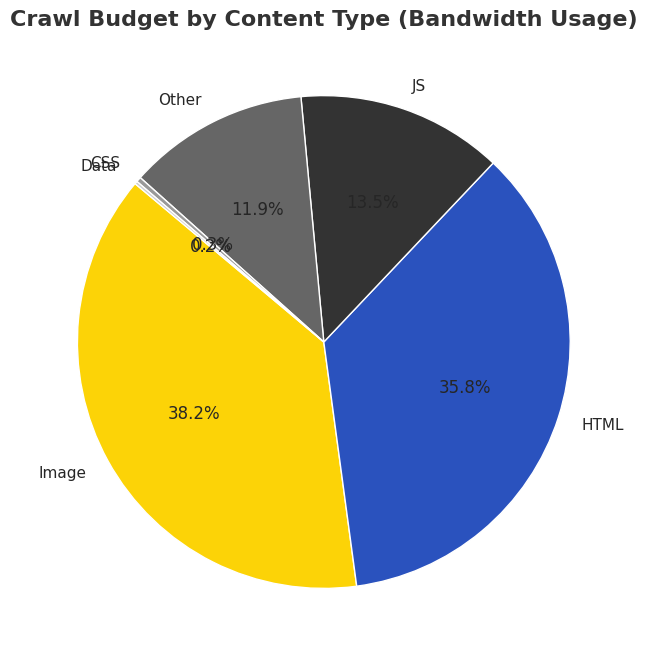

In [52]:
budget_impact = df.groupby('file_type')['bytes_sent'].sum().sort_values(ascending=False).reset_index()
budget_impact['GB'] = budget_impact['bytes_sent'] / (1024**3)

plt.figure(figsize=(8, 8))
# Use rank-based coloring
colors_pie = get_ipr_colors(len(budget_impact), values=budget_impact['bytes_sent'].values)
plt.pie(budget_impact['bytes_sent'], labels=budget_impact['file_type'], autopct='%1.1f%%', colors=colors_pie, startangle=140)
plt.title("Crawl Budget by Content Type (Bandwidth Usage)", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.show()

## Phase 5: Additional Visualization

/tmp/ipython-input-2582535339.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dirs.values, y=top_dirs.index, palette=colors)


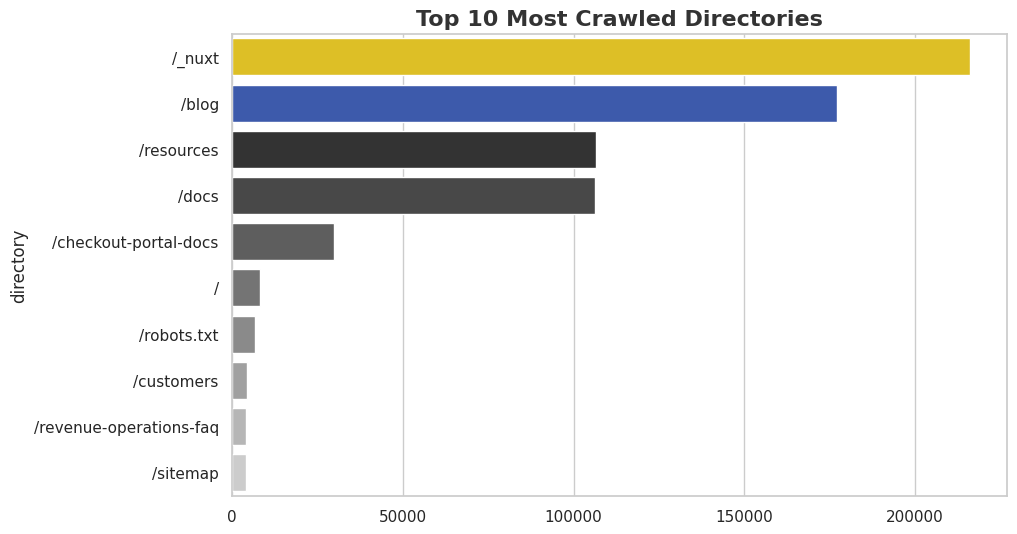

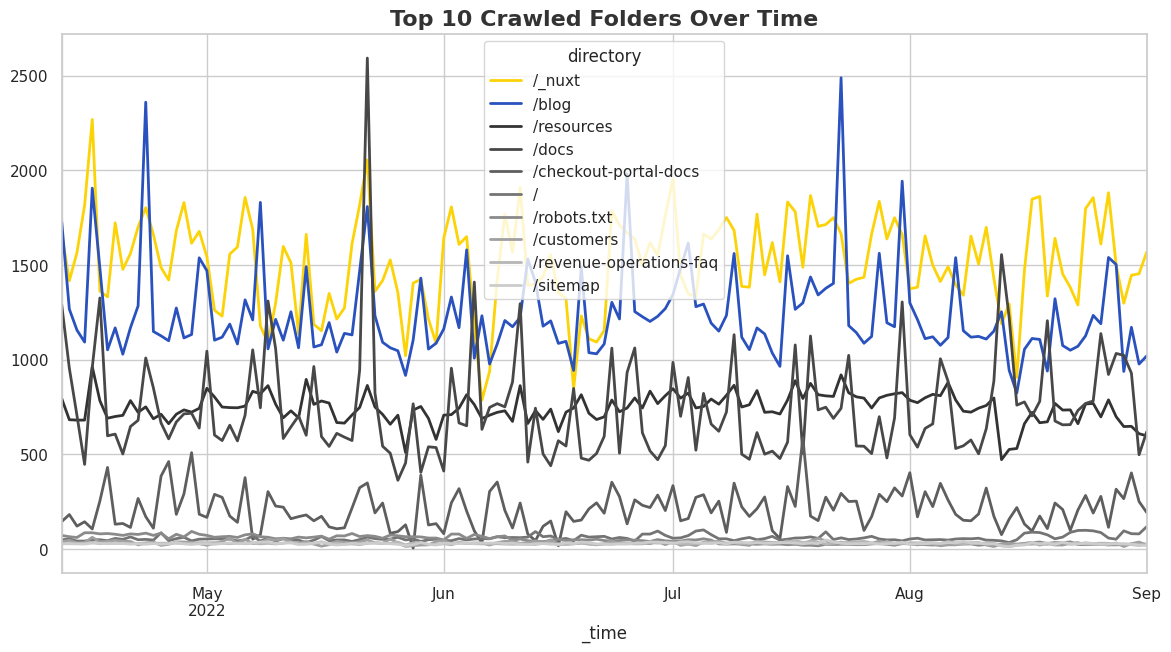

In [53]:
### Module E: Advanced Directory & Performance Analysis

In [ ]:
def get_directory(path, depth=None, folders_set=None):
    if pd.isna(path) or path == '/': return '/'
    parts = [p for p in path.split('/') if p]
    if not parts: return '/'
    
    # If no folders_set is provided, we can't do smart detection, fall back to simple depth
    if folders_set is None:
        d = depth if depth is not None else len(parts)
        return '/' + '/'.join(parts[:d])
    
    # Try to find the longest prefix that is a confirmed folder, up to the desired depth
    max_d = depth if depth is not None else len(parts)
    for i in range(min(len(parts), max_d), 0, -1):
        prefix = '/' + '/'.join(parts[:i])
        if prefix in folders_set:
            return prefix
            
    return '/'

# Identify all confirmed folders (paths that contain other resources)
unique_paths = df['uri_path'].unique()
confirmed_folders = set()
for path in unique_paths:
    if pd.isna(path): continue
    parts = [p for p in path.split('/') if p]
    # Every prefix of a path is a folder that contains the subsequent part
    for i in range(1, len(parts)):
        confirmed_folders.add('/' + '/'.join(parts[:i]))

# Use the global folders set to accurately identify directories without limiting depth
df['directory'] = df['uri_path'].apply(lambda x: get_directory(x, depth=None, folders_set=confirmed_folders))

# Filter to include only HTML pages for directory crawl analysis (exclude static assets as requested)
df_dir_analysis = df[df['file_type'] == 'HTML'].copy()

# 1. Top 10 Most Crawled Directories
top_dirs = df_dir_analysis['directory'].value_counts().head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(top_dirs), values=top_dirs.values)
sns.barplot(x=top_dirs.values, y=top_dirs.index, palette=colors)
plt.title('Top 10 Most Crawled Directories', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 2. Bottom 10 Least Crawled Directories (by Hits)
bottom_dirs = df_dir_analysis['directory'].value_counts().tail(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bottom_dirs), values=bottom_dirs.values)
sns.barplot(x=bottom_dirs.values, y=bottom_dirs.index, palette=colors)
plt.title('Bottom 10 Least Crawled Directories (Total Hits)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 3. Least Crawled Relative to Size (Hits / Unique URLs)
dir_stats = df_dir_analysis.groupby('directory').agg(
    hits=('full_url', 'count'),
    unique_urls=('full_url', 'nunique')
).reset_index()
dir_stats['hits_per_page'] = dir_stats['hits'] / dir_stats['unique_urls']
bottom_relative = dir_stats.sort_values('hits_per_page').head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bottom_relative), values=bottom_relative['hits_per_page'].values)
sns.barplot(x=bottom_relative['hits_per_page'].values, y=bottom_relative['directory'].values, palette=colors)
plt.title('Bottom 10 Directories by Crawl Frequency (Hits/Unique URL)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 4. Performance: Top 10 Directories by Average Latency (ms)
avg_latency = df_dir_analysis.groupby('directory')['time_taken'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(avg_latency), values=avg_latency.values)
sns.barplot(x=avg_latency.values, y=avg_latency.index, palette=colors)
plt.title('Top 10 Directories by Average Latency (ms)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 5. Bandwidth: Top 10 Directories by Total Bandwidth (MB)
total_bandwidth = (df_dir_analysis.groupby('directory')['bytes_sent'].sum() / (1024 * 1024)).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(total_bandwidth), values=total_bandwidth.values)
sns.barplot(x=total_bandwidth.values, y=total_bandwidth.index, palette=colors)
plt.title('Top 10 Directories by Total Bandwidth (MB)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 6. Errors: Top 10 Directories by Error Count (4xx/5xx)
df_dir_analysis['is_error'] = df_dir_analysis['status'].apply(lambda x: x >= 400)
error_counts = df_dir_analysis.groupby('directory')['is_error'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(error_counts), values=error_counts.values)
sns.barplot(x=error_counts.values, y=error_counts.index, palette=colors)
plt.title('Top 10 Directories by Error Count (4xx/5xx)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

top_10_dir_list = top_dirs.index.tolist()
dir_time_series = df_dir_analysis[df_dir_analysis['directory'].isin(top_10_dir_list)].groupby(['directory']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
line_colors = get_ipr_colors(len(top_10_dir_list), values=[top_dirs[d] for d in top_10_dir_list])
dir_time_series[top_10_dir_list].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Top 10 Crawled Folders Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

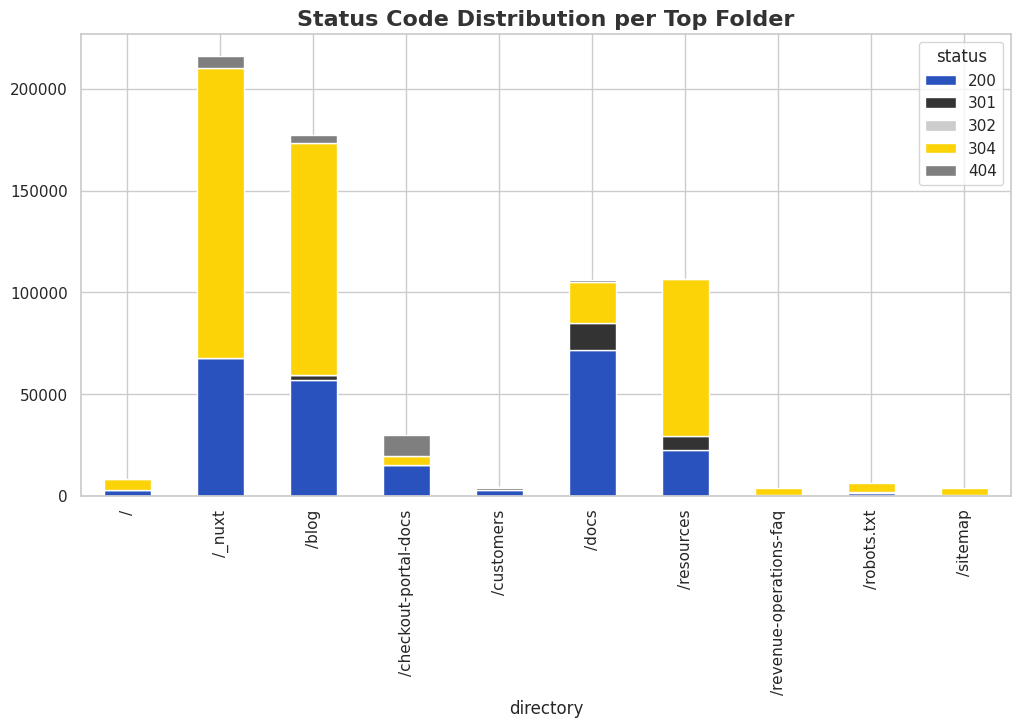

In [54]:
folder_status = df_dir_analysis[df_dir_analysis['directory'].isin(top_dirs.index)].groupby(['directory', 'status']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
global_status_counts = df_dir_analysis['status'].value_counts()
status_colors = get_ipr_colors(len(global_status_counts), values=global_status_counts.values)
status_color_map = dict(zip(global_status_counts.index, status_colors))
plot_colors = [status_color_map.get(s, '#CCCCCC') for s in folder_status.columns]
folder_status.plot(kind='bar', stacked=True, ax=plt.gca(), color=plot_colors)
plt.title('Status Code Distribution per Top Folder', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

In [55]:
def export_all_to_sheets(dataset_list):
    auth.authenticate_user()
    creds, _ = default()
    gc_sheet = gspread.authorize(creds)

    try:
        sh = gc_sheet.open(OUTPUT_SHEET_NAME)
    except gspread.SpreadsheetNotFound:
        sh = gc_sheet.create(OUTPUT_SHEET_NAME)

    timestamp = datetime.now().strftime("%m/%d %H:%M")

    # Create a new worksheet for this consolidated run
    # Increased columns to 100 for horizontal arrangement
    ws = sh.add_worksheet(title=f"Analysis {timestamp}", rows=2000, cols=100)

    curr_col = 1
    for title, df in dataset_list:
        if df is None:
            continue
        if isinstance(df, pd.Series):
            df = df.reset_index()
        if df.empty:
            continue

        # Write Title at Row 1
        title_cell = rowcol_to_a1(1, curr_col)
        ws.update(range_name=title_cell, values=[[title]])

        # Prepare Header and Data
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ['_'.join([str(c) for c in col]).strip() for col in df.columns.values]

        # Convert datetimes to simple strings (m/d/yy) for better chart display
        # Also convert any lists or dictionaries to string representations
        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = df[col].dt.strftime('%m/%d/%y')
            # Check if any element in the column is a list or dictionary
            # and convert the entire column to string type if so.
            elif df[col].apply(lambda x: isinstance(x, (list, dict))).any():
                df[col] = df[col].astype(str)


        header = [f"'{col}" for col in df.columns.tolist()]
        # Use None for NaNs to preserve numeric types while allowing empty cells
        data = df.where(pd.notnull(df), None).values.tolist()

        # Write Header and Data starting at Row 2
        data_cell = rowcol_to_a1(2, curr_col)
        ws.update(range_name=data_cell, values=[header] + data, value_input_option='USER_ENTERED')

        # Move to next starting column: width of current DF + 1 empty column
        curr_col += len(df.columns) + 1

    print(f"All datasets exported successfully! URL: {sh.url}")

# Construct the list of all datasets for export
export_list = [
    ("Bot Type Breakdown", bot_counts if 'bot_counts' in locals() else None),
    ("Bot Type Trends (Daily)", bot_time_series.reset_index() if 'bot_time_series' in locals() else None),
    ("Status Code Summary", status_summary.reset_index() if 'status_summary' in locals() else None),
    ("Status Code Trends (Daily)", status_time_series.reset_index() if 'status_time_series' in locals() else None),
    ("Spider Trap Analysis", trap_details_df if 'trap_details_df' in locals() else None),
    ("Rendering Budget Impact", budget_impact if 'budget_impact' in locals() else None),
    ("Top Most Crawled Directories", top_dirs if 'top_dirs' in locals() else None),
    ("Bottom 10 Directories (Least Crawled)", bottom_dirs if 'bottom_dirs' in locals() else None),
    ("Bottom 10 Directories (Crawl Frequency)", bottom_relative if 'bottom_relative' in locals() else None),
    ("Top 10 Directories (Latency)", avg_latency if 'avg_latency' in locals() else None),
    ("Top 10 Directories (Bandwidth)", total_bandwidth if 'total_bandwidth' in locals() else None),
    ("Top 10 Directories (Errors)", error_counts if 'error_counts' in locals() else None),
    ("Folder Trends (Daily)", dir_time_series.reset_index() if 'dir_time_series' in locals() else None),
    ("Status Code Distribution per Folder", folder_status.reset_index() if 'folder_status' in locals() else None)
]

export_all_to_sheets(export_list)

All datasets exported successfully! URL: https://docs.google.com/spreadsheets/d/1Aw_W_2BsyrDx-aLaBKi6qWBYjAaXvNWggaduqzI8Aes
